# Machine Learning Project

## Problem

Predict whether a company will go bankrupt within the next 1–2 years using 64 financial ratios (covering profitability, leverage, liquidity, and efficiency), and benchmark performance against an Altman Z-score (or its book-value variant) baseline computed from available ratios.

### Prerequsites

Uncommenct some lines if you see some libraries missing

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn

### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


## Exploratory Data Analysis

### Data Loading

In [3]:
df = pd.read_csv("data.csv")
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A57,A58,A59,A60,A61,A62,A63,A64,class,year
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,1
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,1
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,1
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,1
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,1


In [4]:
df.shape

(43405, 66)

In [5]:
df.columns

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21',
       'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31',
       'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41',
       'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51',
       'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61',
       'A62', 'A63', 'A64', 'class', 'year'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      43397 non-null  float64
 1   A2      43397 non-null  float64
 2   A3      43397 non-null  float64
 3   A4      43271 non-null  float64
 4   A5      43316 non-null  float64
 5   A6      43397 non-null  float64
 6   A7      43397 non-null  float64
 7   A8      43311 non-null  float64
 8   A9      43396 non-null  float64
 9   A10     43397 non-null  float64
 10  A11     43361 non-null  float64
 11  A12     43271 non-null  float64
 12  A13     43278 non-null  float64
 13  A14     43397 non-null  float64
 14  A15     43369 non-null  float64
 15  A16     43310 non-null  float64
 16  A17     43311 non-null  float64
 17  A18     43397 non-null  float64
 18  A19     43277 non-null  float64
 19  A20     43278 non-null  float64
 20  A21     37551 non-null  float64
 21  A22     43397 non-null  float64
 22

### Data Quality Checks

In [7]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_pct.head(15)

A37    43.736897
A21    13.486925
A27     6.367930
A60     4.957954
A45     4.946435
A24     2.124179
A64     1.870752
A53     1.870752
A54     1.870752
A28     1.870752
A41     1.737127
A32     0.847829
A52     0.693468
A47     0.684253
A46     0.311024
dtype: float64

In [8]:
df.duplicated().sum()

np.int64(401)

### Target (class) distribution

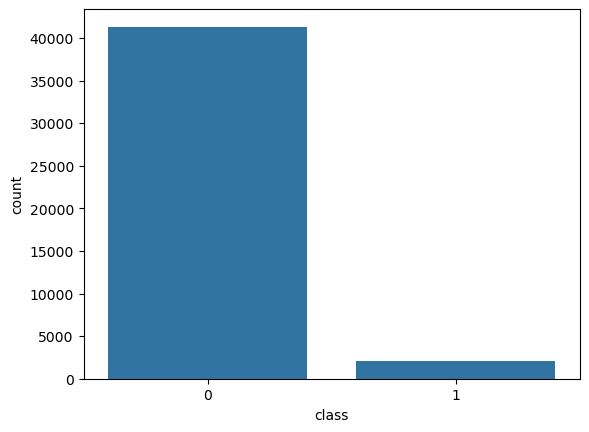

In [9]:
data = df["class"].value_counts()
plt.figure()
sns.barplot(data)
plt.show()

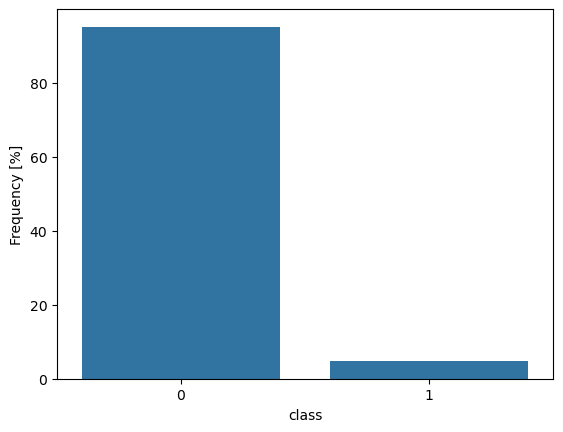

In [10]:
data = df["class"].value_counts(normalize=True) * 100
plt.figure()
sns.barplot(data)
plt.ylabel("Frequency [%]")
plt.show()

### Horizon (year) distribution & dataset selection (1–2 years)

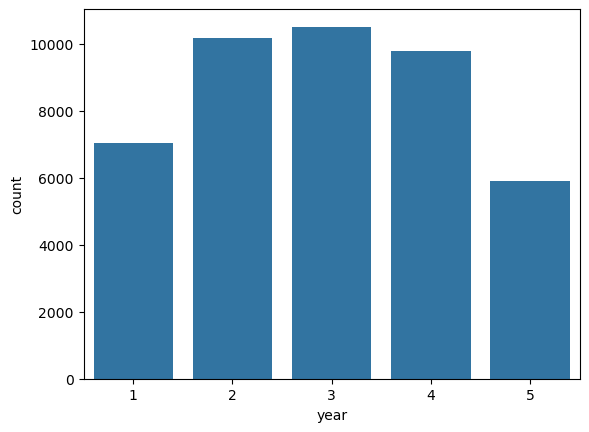

In [11]:
year_counts = df["year"].value_counts().sort_index()
plt.figure()
sns.barplot(year_counts)
plt.show()

This dataset combines five separate files (1stYear–5thYear). Here, the column year indicates which file a record comes from (1–5), not “years until bankruptcy”. In this dataset design, year=4 corresponds to predicting bankruptcy within 2 years, and year=5 corresponds to predicting bankruptcy within 1 year. Therefore, to match our project goal (“bankruptcy within 1–2 years”), we select rows where year ∈ {4,5}.

df_12 shape (rows, cols): (15702, 66)


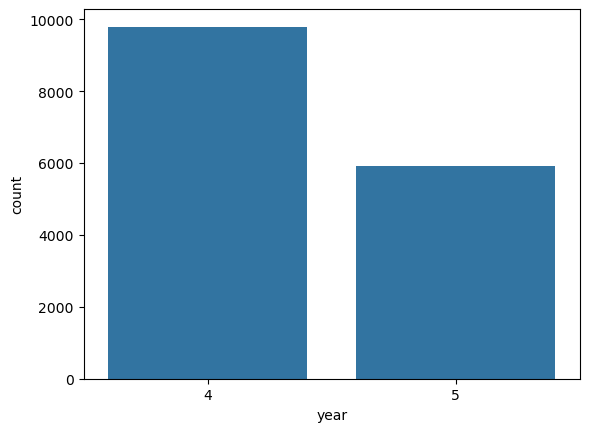

In [12]:
df_12 = df[df["year"].isin([4, 5])].copy()

print("df_12 shape (rows, cols):", df_12.shape)

data = df_12["year"].value_counts().sort_index()
plt.figure()
sns.barplot(data)
plt.show()

In [13]:
horizon_map = {4: 2, 5: 1}
df_12["horizon_years"] = df_12["year"].map(horizon_map)

df_12["horizon_years"].value_counts().sort_index()

horizon_years
1    5910
2    9792
Name: count, dtype: int64

In [14]:
dup_count = df_12.duplicated().sum()
print("Duplicates in df_12:", dup_count)

df_12 = df_12.drop_duplicates()
print("Shape after dropping duplicates:", df_12.shape)

Duplicates in df_12: 142
Shape after dropping duplicates: (15560, 67)


Plot `class` distribution after deleting duplicates

class
0    14639
1      921
Name: count, dtype: int64


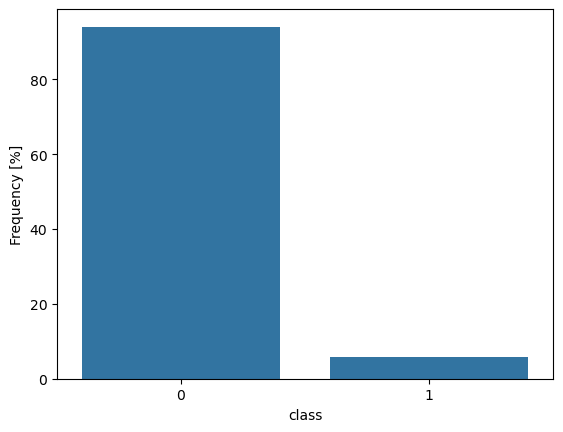

In [15]:
print(df_12["class"].value_counts())
data = df_12["class"].value_counts(normalize=True) * 100

plt.figure()
sns.barplot(data)
plt.ylabel("Frequency [%]")
plt.show()

In [16]:
df_12.groupby("horizon_years")["class"].agg(["count", "mean"])

,count,mean
horizon_years,,
1,5850,0.069744
2,9710,0.052832


### Feature overview + missingness

The following description of features was provided by the dataset creator: https://www.kaggle.com/datasets/stealthtechnologies/predict-bankruptcy-in-poland/discussion/523782

In [17]:
data_dict = {
"A1": "net profit / total assets",
"A2": "total liabilities / total assets",
"A3": "working capital / total assets",
"A4": "current assets / short-term liabilities",
"A5": "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
"A6": "retained earnings / total assets",
"A7": "EBIT / total assets",
"A8": "book value of equity / total liabilities",
"A9": "sales / total assets",
"A10": "equity / total assets",
"A11": "(gross profit + extraordinary items + financial expenses) / total assets",
"A12": "gross profit / short-term liabilities",
"A13": "(gross profit + depreciation) / sales",
"A14": "(gross profit + interest) / total assets",
"A15": "(total liabilities * 365) / (gross profit + depreciation)",
"A16": "(gross profit + depreciation) / total liabilities",
"A17": "total assets / total liabilities",
"A18": "gross profit / total assets",
"A19": "gross profit / sales",
"A20": "(inventory * 365) / sales",
"A21": "sales (n) / sales (n-1)",
"A22": "profit on operating activities / total assets",
"A23": "net profit / sales",
"A24": "gross profit (in 3 years) / total assets",
"A25": "(equity - share capital) / total assets",
"A26": "(net profit + depreciation) / total liabilities",
"A27": "profit on operating activities / financial expenses",
"A28": "working capital / fixed assets",
"A29": "logarithm of total assets",
"A30": "(total liabilities - cash) / sales",
"A31": "(gross profit + interest) / sales",
"A32": "(current liabilities * 365) / cost of products sold",
"A33": "operating expenses / short-term liabilities",
"A34": "operating expenses / total liabilities",
"A35": "profit on sales / total assets",
"A36": "total sales / total assets",
"A37": "(current assets - inventories) / long-term liabilities",
"A38": "constant capital / total assets",
"A39": "profit on sales / sales",
"A40": "(current assets - inventory - receivables) / short-term liabilities",
"A41": "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
"A42": "profit on operating activities / sales",
"A43": "rotation receivables + inventory turnover in days",
"A44": "(receivables * 365) / sales",
"A45": "net profit / inventory",
"A46": "(current assets - inventory) / short-term liabilities",
"A47": "(inventory * 365) / cost of products sold",
"A48": "EBITDA (profit on operating activities - depreciation) / total assets",
"A49": "EBITDA (profit on operating activities - depreciation) / sales",
"A50": "current assets / total liabilities",
"A51": "short-term liabilities / total assets",
"A52": "(short-term liabilities * 365) / cost of products sold",
"A53": "equity / fixed assets",
"A54": "constant capital / fixed assets",
"A55": "working capital",
"A56": "(sales - cost of products sold) / sales",
"A57": "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
"A58": "total costs / total sales",
"A59": "long-term liabilities / equity",
"A60": "sales / inventory",
"A61": "sales / receivables",
"A62": "(short-term liabilities * 365) / sales",
"A63": "sales / short-term liabilities",
"A64": "sales / fixed assets"
}

In [18]:
# How many columns and what are they?
print("Columns:", df_12.shape[1])

# Data types overview
df_12.dtypes.value_counts()

Columns: 67


float64    64
int64       3
Name: count, dtype: int64

In [19]:
missing_pct_12 = df_12.isna().mean().sort_values(ascending=False) * 100
missing_pct_12.head(15)

A37    44.595116
A27     6.587404
A60     5.649100
A45     5.642674
A24     2.223650
A28     2.152956
A53     2.152956
A64     2.152956
A54     2.152956
A41     1.741645
A21     1.677378
A32     0.906170
A52     0.713368
A47     0.687661
A40     0.411311
dtype: float64

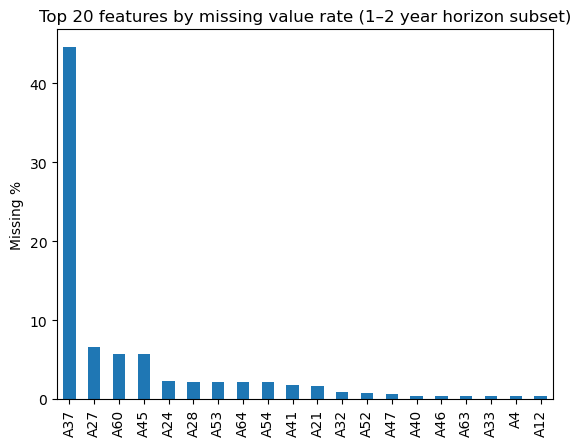

In [20]:
import matplotlib.pyplot as plt

plt.figure()
missing_pct_12.head(20).plot(kind="bar")
plt.title("Top 20 features by missing value rate (1–2 year horizon subset)")
plt.ylabel("Missing %")
plt.show()

Feature A37 [(current assets - inventories) / long-term liabilities] contains to0 many missing values, therefore we drop this feature.

In [21]:
df_12.drop(columns=["A37"], inplace=True)

In [22]:
# Summary statistics for a quick view
df_12.drop(columns=["class", "year", "horizon_years"]).describe().T.head(15)

,count,mean,std,min,25%,50%,75%,max
A1,15556.0,0.018053,3.808742,-4.638900e+02,0.002230,0.043131,0.113477,87.459
A2,15556.0,0.548394,5.079889,-4.308700e+02,0.261682,0.463040,0.679022,446.910
A3,15556.0,0.152186,3.688953,-4.459100e+02,0.028643,0.208030,0.414640,28.336
A4,15496.0,6.947215,237.324897,-4.031100e-01,1.062300,1.615050,2.896325,27146.000
A5,15528.0,55.756465,17669.577566,-1.076400e+06,-48.377000,0.088742,52.992500,1250100.000
A6,15556.0,-0.029375,8.192734,-4.868200e+02,0.000000,0.000000,0.079351,543.250
A7,15556.0,-0.005714,5.597491,-5.174800e+02,0.003845,0.051075,0.130785,38.618
A8,15523.0,14.655840,557.994655,-3.735100e+00,0.446240,1.106200,2.707900,53209.000
A9,15559.0,1.776836,14.054207,-3.496000e+00,1.010200,1.152900,1.920800,1704.800
A10,15556.0,0.446764,5.087227,-4.459100e+02,0.301800,0.514300,0.716017,339.850


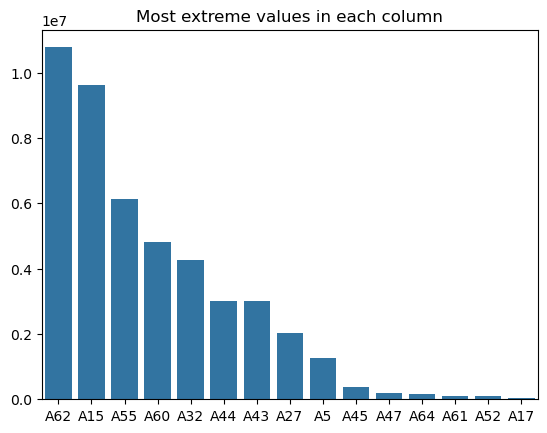

In [23]:
# “Most extreme” columns by max absolute value
features_only = df_12.drop(columns=["class", "year", "horizon_years"])
max_abs = features_only.abs().max().sort_values(ascending=False)
plt.figure()
sns.barplot(max_abs[:15])
plt.title("Most extreme values in each column")
plt.show()

**Quick relationships / insights**

In [24]:
import numpy as np

y = df_12["class"].astype(int)

X = df_12.drop(columns=["class", "year", "horizon_years"]).copy()

# Replace inf with NaN so we can safely impute later
X = X.replace([np.inf, -np.inf], np.nan)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (15560, 63)
y shape: (15560,)


In [25]:
inf_count = np.isinf(X.to_numpy()).sum()
nan_count = np.isnan(X.to_numpy()).sum()
print("inf count:", inf_count)
print("NaN count:", nan_count)

inf count: 0
NaN count: 6410


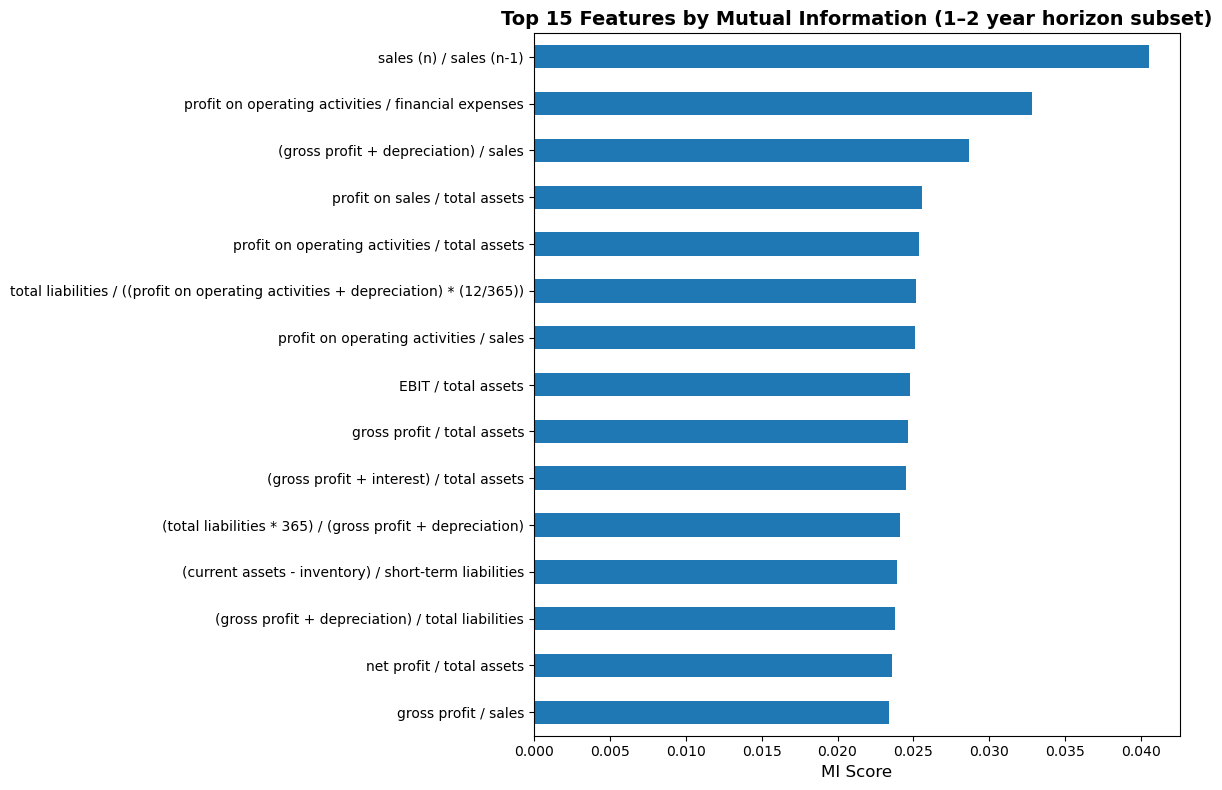

In [63]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# temporary imputation only for MI calculation
X_tmp = X.fillna(X.median(numeric_only=True))

mi = mutual_info_classif(X_tmp, y, random_state=42)
mi_s = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Create readable mutual information series
mi_readable = mi_s.copy()
mi_readable.index = mi_readable.index.map(lambda x: data_dict.get(x, x))

plt.figure(figsize=(12, 8))
mi_readable.head(15).sort_values().plot(kind="barh")
plt.title("Top 15 Features by Mutual Information (1–2 year horizon subset)", fontsize=14, fontweight='bold')
plt.xlabel("MI Score", fontsize=12)
plt.tight_layout()
plt.show()

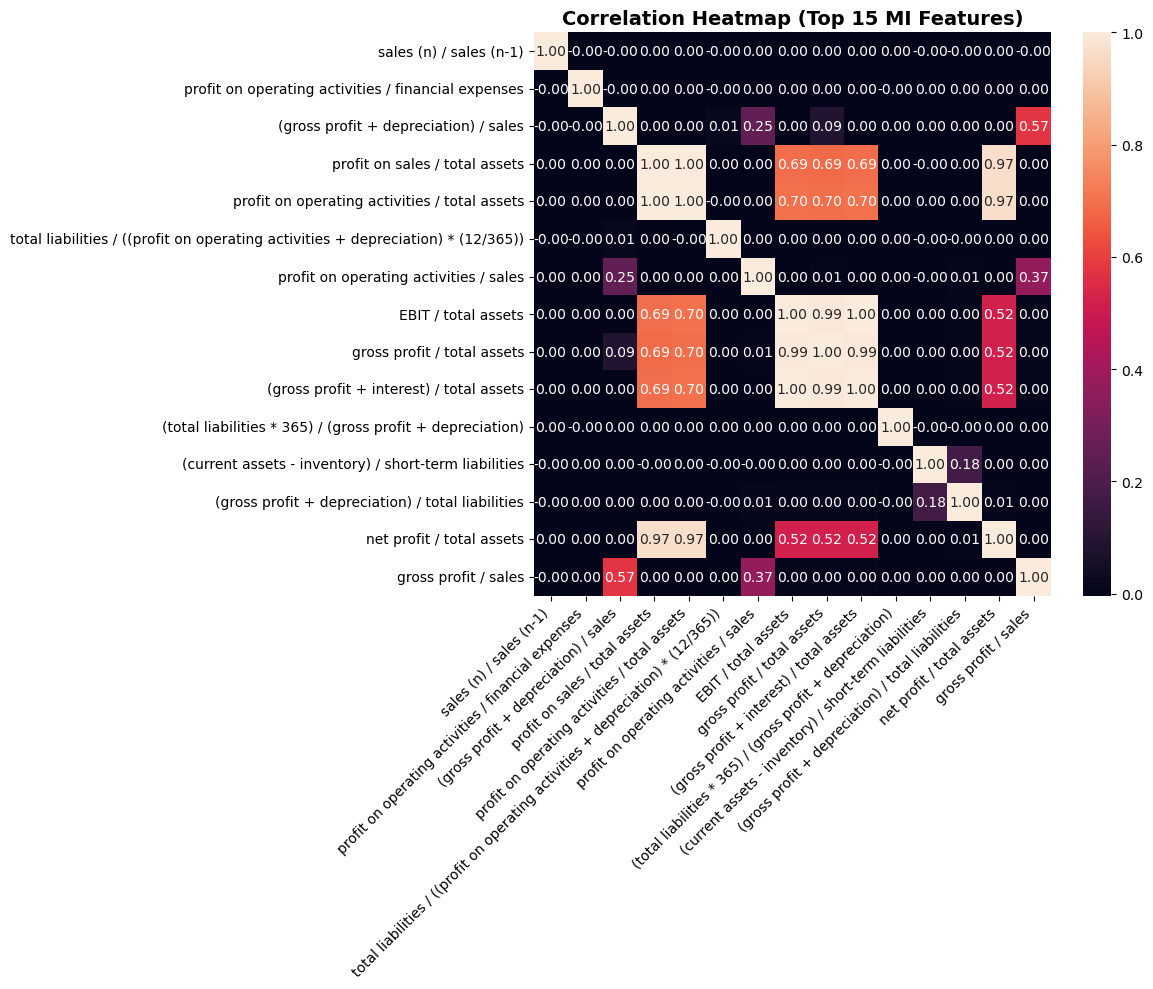

In [64]:
top15 = mi_s.head(15).index.tolist()
corr = X_tmp[top15].corr()

plt.figure(figsize=(12, 10))
# Create readable labels for heatmap
readable_labels = [data_dict.get(col, col) for col in top15]

sns.heatmap(corr, annot=True, fmt=".2f", xticklabels=readable_labels, yticklabels=readable_labels)
plt.title("Correlation Heatmap (Top 15 MI Features)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

**What this implies for modeling?**

In [28]:
counts = y.value_counts()
print("Counts:\n", counts)
print("Bankruptcy rate (%):", round(100 * counts.get(1,0) / len(y), 3))

Counts:
 class
0    14639
1      921
Name: count, dtype: int64
Bankruptcy rate (%): 5.919


**Imbalanced target** (~5.9% bankrupt) → accuracy alone is misleading

* **Metrics**: Precision, Recall, F1-score, PR-AUC (optionally ROC-AUC)

* **Validation**: stratified train/test split
*  **SMOTE** for data augmentation

## Models

### Modeling setup

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train bankrupt rate:", y_train.mean())
print("Test bankrupt rate:", y_test.mean())

Train size: (12448, 63)  Test size: (3112, 63)
Train bankrupt rate: 0.05920629820051414
Test bankrupt rate: 0.05912596401028278


In [30]:
preprocess = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=5))
])

* **Missing values:** median imputation

* **Scaling:** standardization for scale-sensitive models

* **Imbalance**: `class_weight='balanced'` and/or threshold tuning

* **No leakage**: preprocessing inside Pipeline

### Random Forest

In [31]:
rf_pipeline = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1, verbose=1))
])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20],
    'rf__min_samples_split': [5, 10],
    'rf__min_samples_leaf': [2, 4],
    'rf__class_weight': ['balanced', 'balanced_subsample']
}

# GridSearchCV with cross-validation and PR-AUC scoring
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='average_precision',  # Optimize for PR-AUC
    n_jobs=-1,
    verbose=1
)

print("Tuning Random Forest with SMOTE...")
grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best CV PR-AUC Score: {grid_search.best_score_:.4f}")

# Use best model for predictions
best_rf_pipeline = grid_search.best_estimator_
y_pred_proba = best_rf_pipeline.predict_proba(X_test)[:, 1]
y_pred = best_rf_pipeline.predict(X_test)

print("\nRandom Forest Model (optimized) trained successfully!")

Tuning Random Forest with SMOTE...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.1s



Best parameters found:
{'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Best CV PR-AUC Score: 0.4410

Random Forest Model (optimized) trained successfully!


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished


In [32]:
# Evaluation metrics before threshold tuning
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=== Random Forest Performance (Default Threshold=0.5) ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-bankrupt', 'Bankrupt']))

=== Random Forest Performance (Default Threshold=0.5) ===
Precision: 0.4297
Recall: 0.5978
F1-Score: 0.5000
PR-AUC: 0.4388
ROC-AUC: 0.9100

Confusion Matrix:
[[2782  146]
 [  74  110]]

Classification Report:
              precision    recall  f1-score   support

Non-bankrupt       0.97      0.95      0.96      2928
    Bankrupt       0.43      0.60      0.50       184

    accuracy                           0.93      3112
   macro avg       0.70      0.77      0.73      3112
weighted avg       0.94      0.93      0.93      3112



In [33]:
# Threshold tuning to maximize F1-score
from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_proba)

f1_scores = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1] + 1e-10)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"Optimal threshold for F1-score: {best_threshold:.4f}")
print(f"F1-score at optimal threshold: {f1_scores[best_threshold_idx]:.4f}")

# Apply optimal threshold
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

precision_opt = precision_score(y_test, y_pred_optimized)
recall_opt = recall_score(y_test, y_pred_optimized)
f1_opt = f1_score(y_test, y_pred_optimized)

print("\n=== Random Forest Performance (Optimized Threshold) ===")
print(f"Threshold: {best_threshold:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimized))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=['Non-bankrupt', 'Bankrupt']))

Optimal threshold for F1-score: 0.5238
F1-score at optimal threshold: 0.5109

=== Random Forest Performance (Optimized Threshold) ===
Threshold: 0.5238
Precision: 0.4626
Recall: 0.5707
F1-Score: 0.5109
PR-AUC: 0.4388

Confusion Matrix:
[[2806  122]
 [  79  105]]

Classification Report:
              precision    recall  f1-score   support

Non-bankrupt       0.97      0.96      0.97      2928
    Bankrupt       0.46      0.57      0.51       184

    accuracy                           0.94      3112
   macro avg       0.72      0.76      0.74      3112
weighted avg       0.94      0.94      0.94      3112



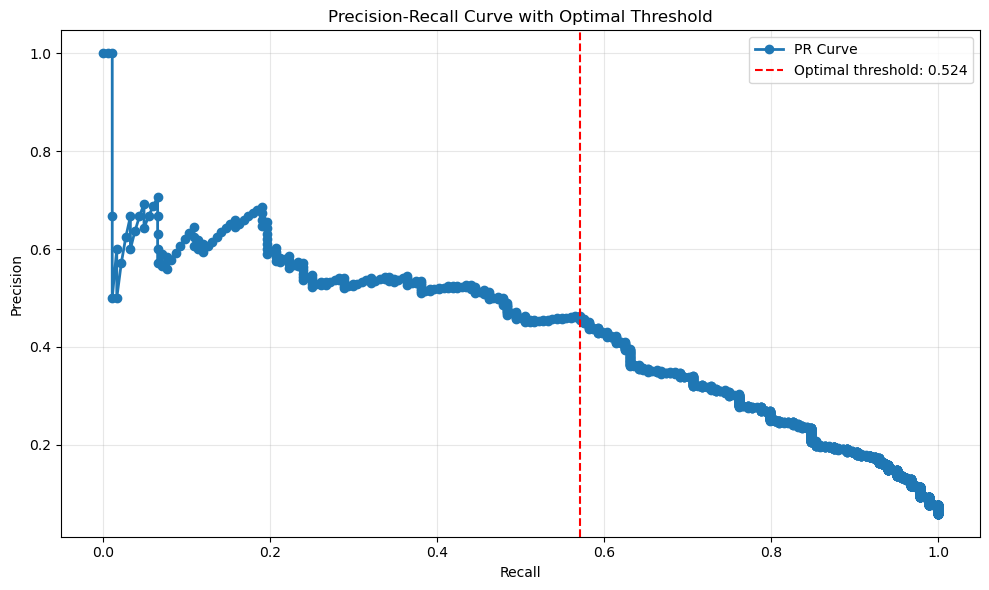

In [ ]:
# Visualize Precision-Recall curve with threshold annotation
plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, marker='o', linewidth=2, label='PR Curve')
plt.axvline(recall_vals[best_threshold_idx], color='r', linestyle='--', label=f'Optimal threshold: {best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

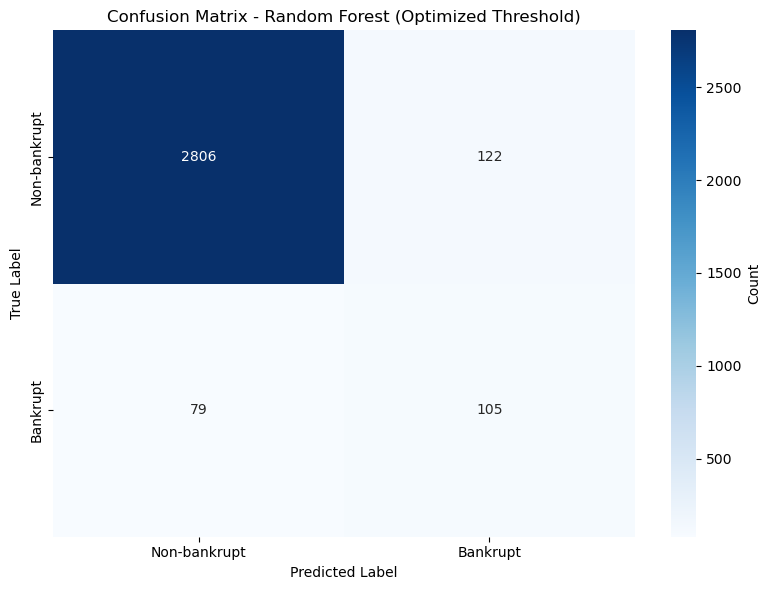

True Negatives (TN): 2806
False Positives (FP): 122
False Negatives (FN): 79
True Positives (TP): 105


In [35]:
import seaborn as sns

# Confusion Matrix Visualization for Random Forest (Optimized)
cm_rf = confusion_matrix(y_test, y_pred_optimized)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-bankrupt', 'Bankrupt'],
            yticklabels=['Non-bankrupt', 'Bankrupt'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest (Optimized Threshold)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print interpretation
tn, fp, fn, tp = cm_rf.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

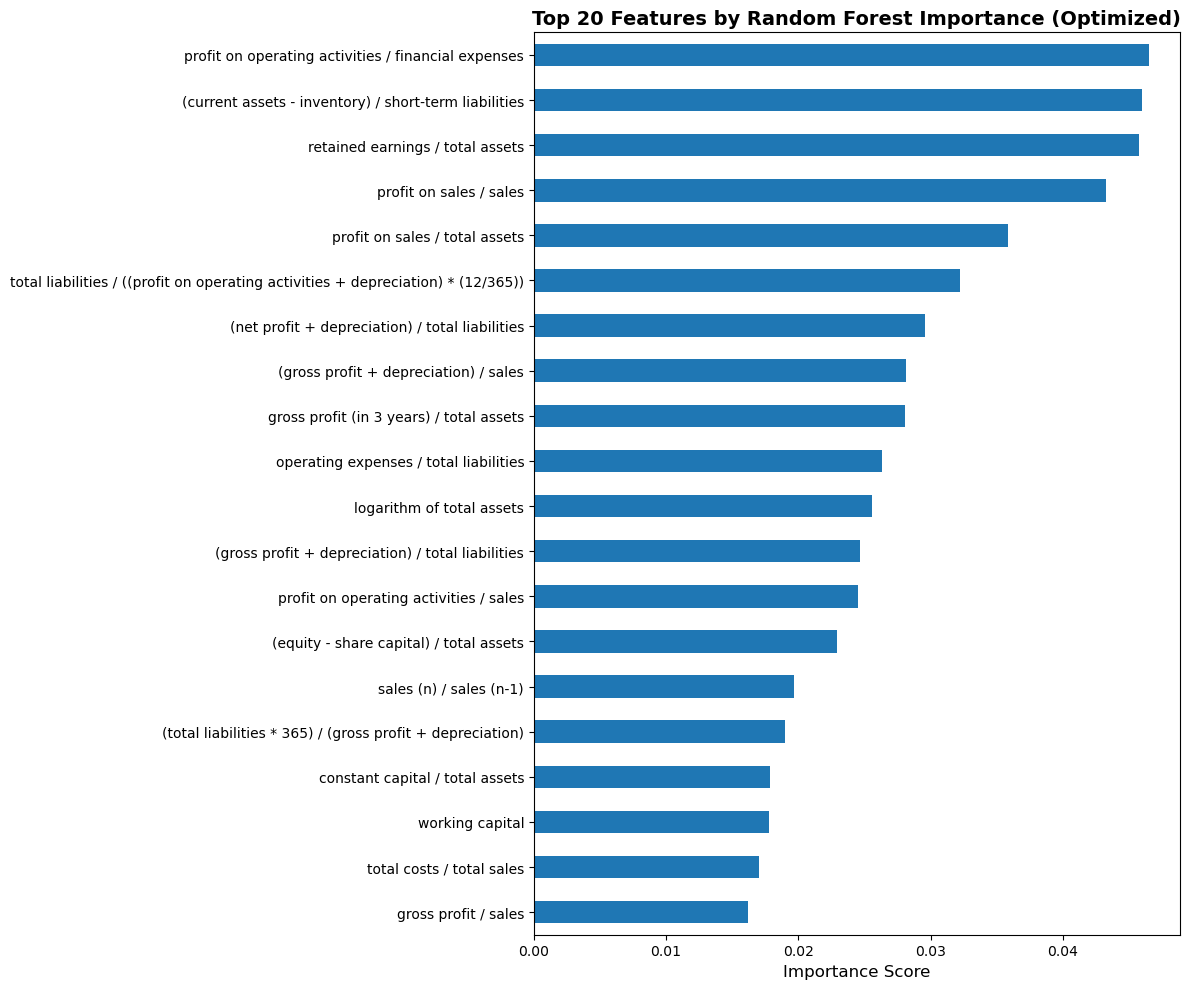

In [61]:
# Feature importance from optimized Random Forest
feature_importance = best_rf_pipeline.named_steps['rf'].feature_importances_
fi_series = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)

# Create readable feature importance series
fi_readable = fi_series.copy()
fi_readable.index = fi_readable.index.map(lambda x: data_dict.get(x, x))

plt.figure(figsize=(12, 10))
fi_readable.head(20).sort_values().plot(kind="barh")
plt.title("Top 20 Features by Random Forest Importance (Optimized)", fontsize=14, fontweight='bold')
plt.xlabel("Importance Score", fontsize=12)
plt.tight_layout()
plt.show()

### Logistic Regression

In [37]:
# Logistic Regression with Grid Search and evaluation
lr_pipeline = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("lr", LogisticRegression(random_state=42, 
                              max_iter=1000, 
                              n_jobs=-1, 
                              solver="lbfgs",
                              class_weight="balanced",
                              verbose=1))
])

# Hyperparameter grid for Logistic Regression (to mmany parameters cause the )
lr_param_grid = {
    'lr__C': [0.1, 1, 10, np.inf],
}

# GridSearchCV with cross-validation
lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=5,
    scoring='average_precision',
    n_jobs=-1,
    verbose=2
)

print("Tuning Logistic Regression with SMOTE...")
lr_grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(lr_grid_search.best_params_)
print(f"Best CV PR-AUC Score: {lr_grid_search.best_score_:.4f}")

# Use best model for predictions
best_lr_pipeline = lr_grid_search.best_estimator_
y_pred_lr_proba = best_lr_pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = best_lr_pipeline.predict(X_test)

print("\nLogistic Regression (optimized) trained successfully!")

Tuning Logistic Regression with SMOTE...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters found:
{'lr__C': inf}
Best CV PR-AUC Score: 0.2338

Logistic Regression (optimized) trained successfully!


In [38]:
# Evaluation metrics before threshold tuning
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
pr_auc_lr = average_precision_score(y_test, y_pred_lr_proba)
roc_auc_lr = roc_auc_score(y_test, y_pred_lr_proba)

print("=== Logistic Regression Performance (Default Threshold=0.5) ===")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")
print(f"PR-AUC: {pr_auc_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Non-bankrupt', 'Bankrupt']))

=== Logistic Regression Performance (Default Threshold=0.5) ===
Precision: 0.1525
Recall: 0.6522
F1-Score: 0.2472
PR-AUC: 0.1920
ROC-AUC: 0.7709

Confusion Matrix:
[[2261  667]
 [  64  120]]

Classification Report:
              precision    recall  f1-score   support

Non-bankrupt       0.97      0.77      0.86      2928
    Bankrupt       0.15      0.65      0.25       184

    accuracy                           0.77      3112
   macro avg       0.56      0.71      0.55      3112
weighted avg       0.92      0.77      0.82      3112



In [39]:
# Threshold tuning to maximize F1-score for Logistic Regression
from sklearn.metrics import precision_recall_curve

precision_vals_lr, recall_vals_lr, thresholds_lr = precision_recall_curve(y_test, y_pred_lr_proba)

f1_scores_lr = 2 * (precision_vals_lr[:-1] * recall_vals_lr[:-1]) / (precision_vals_lr[:-1] + recall_vals_lr[:-1] + 1e-10)
best_threshold_idx_lr = np.argmax(f1_scores_lr)
best_threshold_lr = thresholds_lr[best_threshold_idx_lr]

print(f"Optimal threshold for F1-score: {best_threshold_lr:.4f}")
print(f"F1-score at optimal threshold: {f1_scores_lr[best_threshold_idx_lr]:.4f}")

# Apply optimal threshold
y_pred_lr_optimized = (y_pred_lr_proba >= best_threshold_lr).astype(int)

precision_lr_opt = precision_score(y_test, y_pred_lr_optimized)
recall_lr_opt = recall_score(y_test, y_pred_lr_optimized)
f1_lr_opt = f1_score(y_test, y_pred_lr_optimized)

print("\n=== Logistic Regression Performance (Optimized Threshold) ===")
print(f"Threshold: {best_threshold_lr:.4f}")
print(f"Precision: {precision_lr_opt:.4f}")
print(f"Recall: {recall_lr_opt:.4f}")
print(f"F1-Score: {f1_lr_opt:.4f}")
print(f"PR-AUC: {pr_auc_lr:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_optimized))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_optimized, target_names=['Non-bankrupt', 'Bankrupt']))

Optimal threshold for F1-score: 0.6209
F1-score at optimal threshold: 0.3148

=== Logistic Regression Performance (Optimized Threshold) ===
Threshold: 0.6209
Precision: 0.2347
Recall: 0.4783
F1-Score: 0.3148
PR-AUC: 0.1920

Confusion Matrix:
[[2641  287]
 [  96   88]]

Classification Report:
              precision    recall  f1-score   support

Non-bankrupt       0.96      0.90      0.93      2928
    Bankrupt       0.23      0.48      0.31       184

    accuracy                           0.88      3112
   macro avg       0.60      0.69      0.62      3112
weighted avg       0.92      0.88      0.90      3112



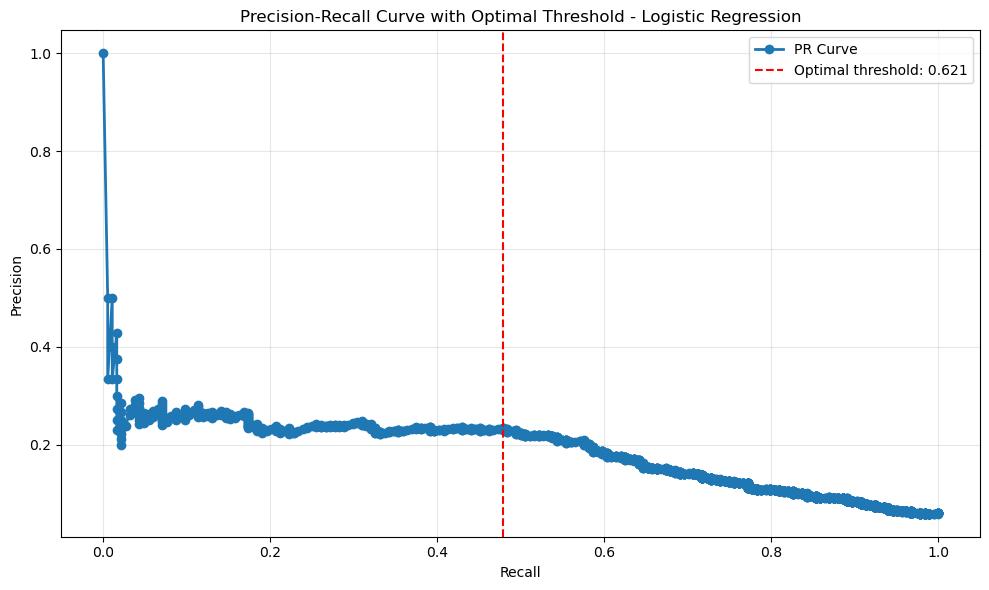

In [40]:
# Visualize Precision-Recall curve with threshold annotation for Logistic Regression
plt.figure(figsize=(10, 6))
plt.plot(recall_vals_lr, precision_vals_lr, marker='o', linewidth=2, label='PR Curve')
plt.axvline(recall_vals_lr[best_threshold_idx_lr], color='r', linestyle='--', label=f'Optimal threshold: {best_threshold_lr:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold - Logistic Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

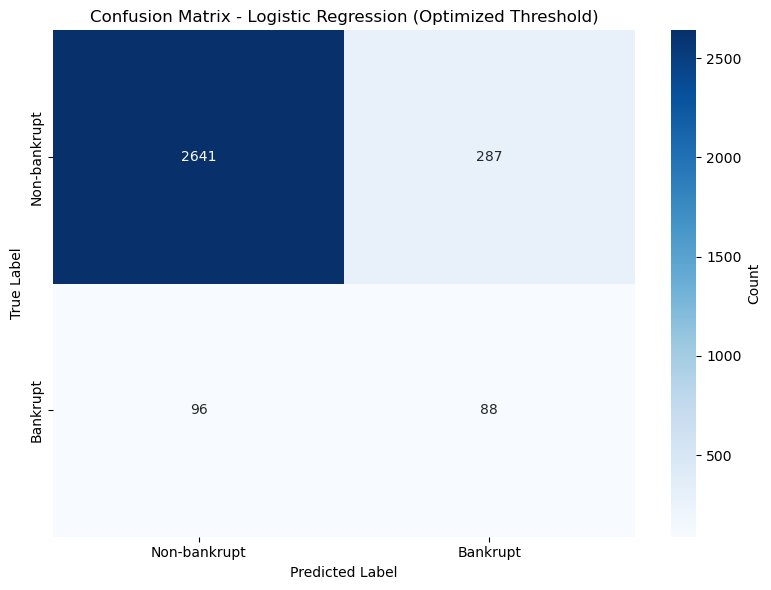

True Negatives (TN): 2641
False Positives (FP): 287
False Negatives (FN): 96
True Positives (TP): 88


In [41]:
# Confusion Matrix Visualization for Logistic Regression (Optimized)
cm_lr = confusion_matrix(y_test, y_pred_lr_optimized)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-bankrupt', 'Bankrupt'],
            yticklabels=['Non-bankrupt', 'Bankrupt'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Logistic Regression (Optimized Threshold)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print interpretation
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
print(f"True Negatives (TN): {tn_lr}")
print(f"False Positives (FP): {fp_lr}")
print(f"False Negatives (FN): {fn_lr}")
print(f"True Positives (TP): {tp_lr}")

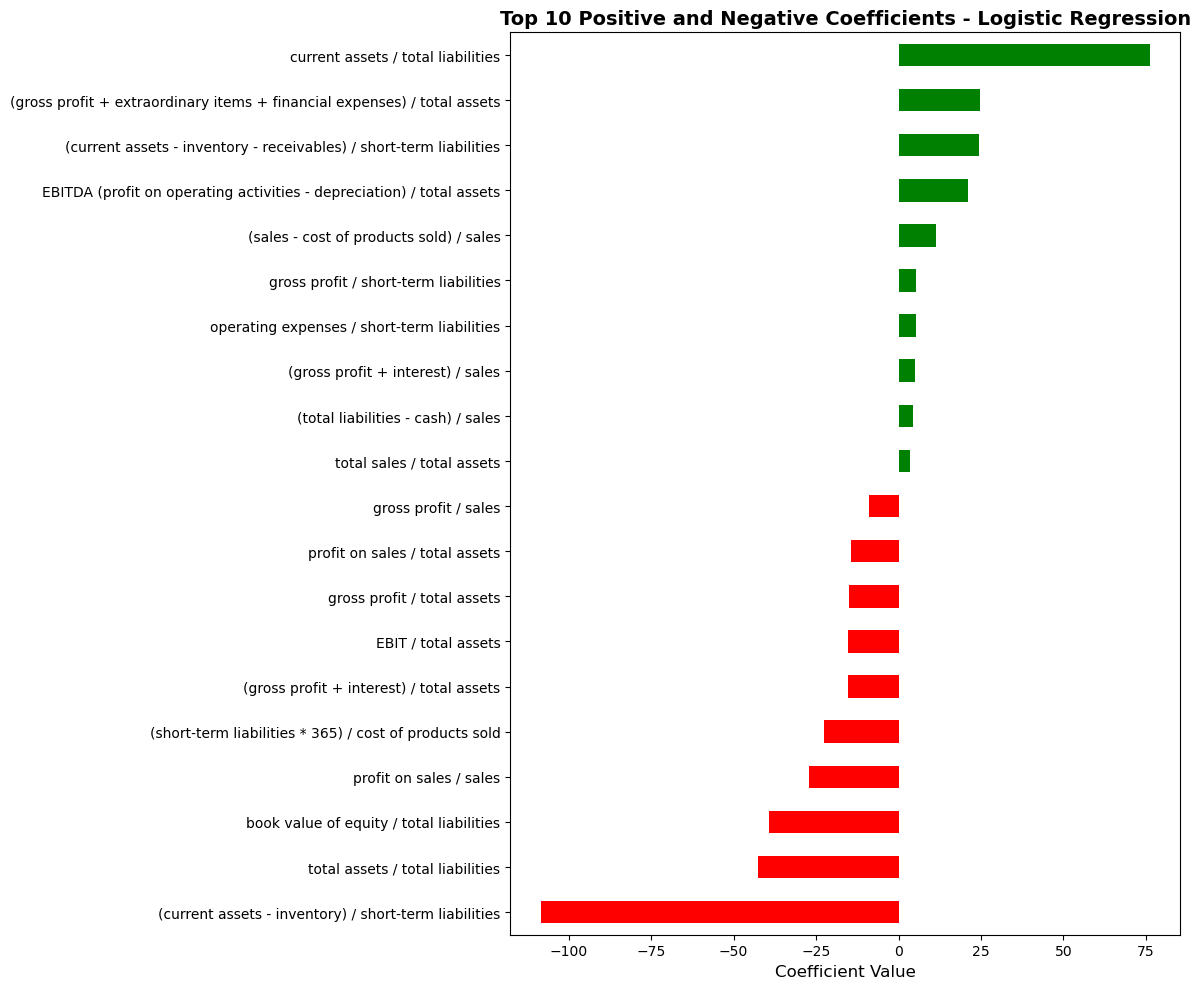

In [62]:
# Feature coefficients from optimized Logistic Regression
# Get coefficients from the fitted LogisticRegression model
lr_model = best_lr_pipeline.named_steps['lr']
coefficients = lr_model.coef_[0]
coef_series = pd.Series(coefficients, index=X.columns).sort_values(ascending=False)

# Create readable coefficient series
coef_readable = coef_series.copy()
coef_readable.index = coef_readable.index.map(lambda x: data_dict.get(x, x))

plt.figure(figsize=(12, 10))
# Plot top positive and top negative coefficients
top_n = 10
top_positive = coef_readable.head(top_n).sort_values()
top_negative = coef_readable.tail(top_n).sort_values()

combined = pd.concat([top_negative, top_positive])
combined.plot(kind="barh", color=['red' if x < 0 else 'green' for x in combined.values])
plt.title("Top 10 Positive and Negative Coefficients - Logistic Regression", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value", fontsize=12)
plt.tight_layout()
plt.show()

In [43]:
# Support Vector Machine with Grid Search and evaluation
svm_pipeline = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("svm", SVC(random_state=42, probability=True))
])

# # Hyperparameter grid for SVM
# svm_param_grid = {
#     'svm__C': [0.1, 1, 10, 100],
#     'svm__kernel': ['rbf', 'linear'],
#     'svm__gamma': ['scale', 'auto']
# }
# Hyperparameter grid for SVM
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['rbf', 'linear'],
}

# GridSearchCV with cross-validation
svm_grid_search = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    cv=2,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

print("Tuning Support Vector Machine with SMOTE...")
svm_grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(svm_grid_search.best_params_)
print(f"Best CV PR-AUC Score: {svm_grid_search.best_score_:.4f}")

# Use best model for predictions
best_svm_pipeline = svm_grid_search.best_estimator_
y_pred_svm_proba = best_svm_pipeline.predict_proba(X_test)[:, 1]
y_pred_svm = best_svm_pipeline.predict(X_test)

print("\nSupport Vector Machine (optimized) trained successfully!")

Tuning Support Vector Machine with SMOTE...
Fitting 2 folds for each of 6 candidates, totalling 12 fits

Best parameters found:
{'svm__C': 10, 'svm__kernel': 'linear'}
Best CV PR-AUC Score: 0.2082

Support Vector Machine (optimized) trained successfully!


In [52]:
# Evaluation metrics before threshold tuning
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
pr_auc_svm = average_precision_score(y_test, y_pred_svm_proba)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm_proba)

print("=== Support Vector Machine Performance (Default Threshold=0.5) ===")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")
print(f"PR-AUC: {pr_auc_svm:.4f}")
print(f"ROC-AUC: {roc_auc_svm:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Non-bankrupt', 'Bankrupt']))

=== Support Vector Machine Performance (Default Threshold=0.5) ===
Precision: 0.1708
Recall: 0.6413
F1-Score: 0.2697
PR-AUC: 0.1878
ROC-AUC: 0.7701

Confusion Matrix:
[[2355  573]
 [  66  118]]

Classification Report:
              precision    recall  f1-score   support

Non-bankrupt       0.97      0.80      0.88      2928
    Bankrupt       0.17      0.64      0.27       184

    accuracy                           0.79      3112
   macro avg       0.57      0.72      0.58      3112
weighted avg       0.93      0.79      0.84      3112



In [53]:
# Threshold tuning to maximize F1-score for SVM
from sklearn.metrics import precision_recall_curve

precision_vals_svm, recall_vals_svm, thresholds_svm = precision_recall_curve(y_test, y_pred_svm_proba)

f1_scores_svm = 2 * (precision_vals_svm[:-1] * recall_vals_svm[:-1]) / (precision_vals_svm[:-1] + recall_vals_svm[:-1] + 1e-10)
best_threshold_idx_svm = np.argmax(f1_scores_svm)
best_threshold_svm = thresholds_svm[best_threshold_idx_svm]

print(f"Optimal threshold for F1-score: {best_threshold_svm:.4f}")
print(f"F1-score at optimal threshold: {f1_scores_svm[best_threshold_idx_svm]:.4f}")

# Apply optimal threshold
y_pred_svm_optimized = (y_pred_svm_proba >= best_threshold_svm).astype(int)

precision_svm_opt = precision_score(y_test, y_pred_svm_optimized)
recall_svm_opt = recall_score(y_test, y_pred_svm_optimized)
f1_svm_opt = f1_score(y_test, y_pred_svm_optimized)

print("\n=== Support Vector Machine Performance (Optimized Threshold) ===")
print(f"Threshold: {best_threshold_svm:.4f}")
print(f"Precision: {precision_svm_opt:.4f}")
print(f"Recall: {recall_svm_opt:.4f}")
print(f"F1-Score: {f1_svm_opt:.4f}")
print(f"PR-AUC: {pr_auc_svm:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm_optimized))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_optimized, target_names=['Non-bankrupt', 'Bankrupt']))

Optimal threshold for F1-score: 0.5604
F1-score at optimal threshold: 0.3114

=== Support Vector Machine Performance (Optimized Threshold) ===
Threshold: 0.5604
Precision: 0.2210
Recall: 0.5272
F1-Score: 0.3114
PR-AUC: 0.1878

Confusion Matrix:
[[2586  342]
 [  87   97]]

Classification Report:
              precision    recall  f1-score   support

Non-bankrupt       0.97      0.88      0.92      2928
    Bankrupt       0.22      0.53      0.31       184

    accuracy                           0.86      3112
   macro avg       0.59      0.71      0.62      3112
weighted avg       0.92      0.86      0.89      3112



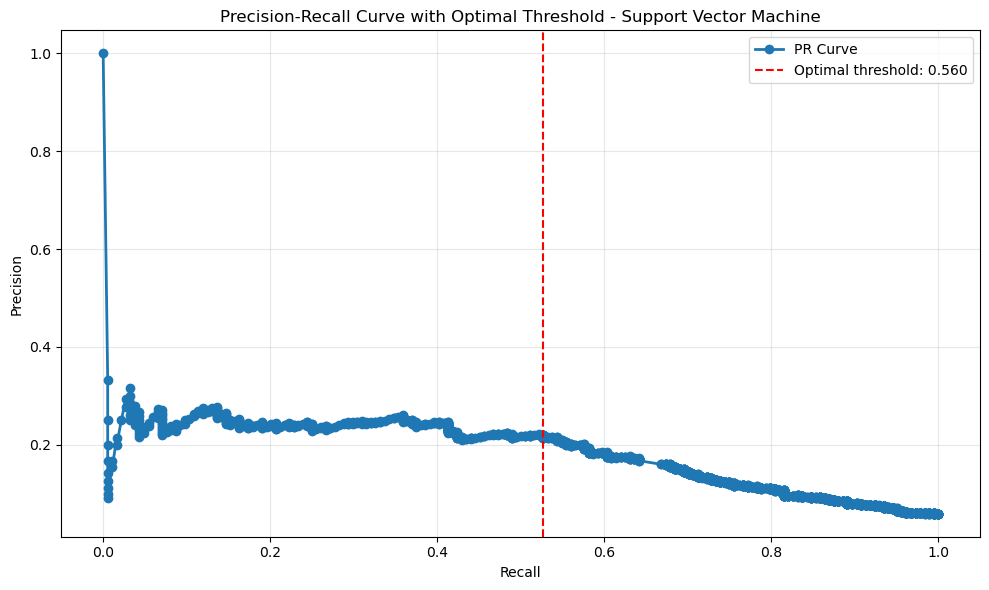

In [46]:
# Visualize Precision-Recall curve with threshold annotation for SVM
plt.figure(figsize=(10, 6))
plt.plot(recall_vals_svm, precision_vals_svm, marker='o', linewidth=2, label='PR Curve')
plt.axvline(recall_vals_svm[best_threshold_idx_svm], color='r', linestyle='--', label=f'Optimal threshold: {best_threshold_svm:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold - Support Vector Machine')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

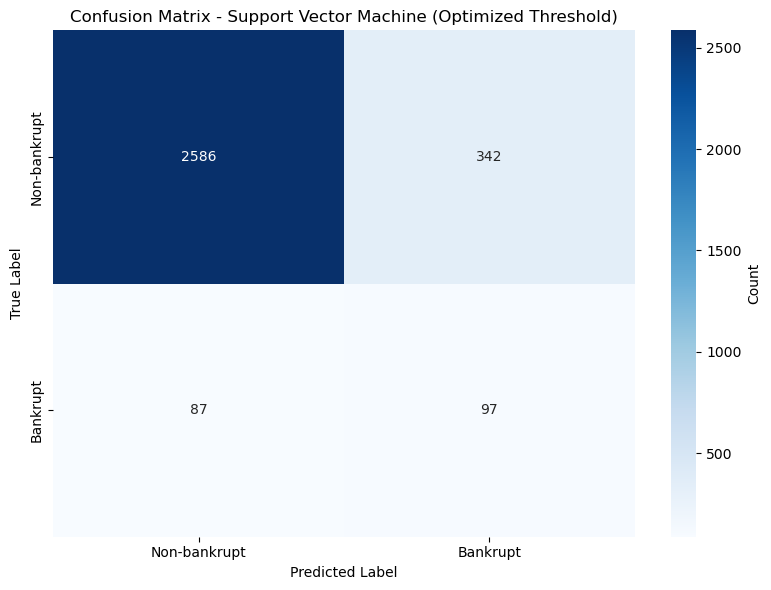

True Negatives (TN): 2586
False Positives (FP): 342
False Negatives (FN): 87
True Positives (TP): 97


In [47]:
# Confusion Matrix Visualization for SVM (Optimized)
cm_svm = confusion_matrix(y_test, y_pred_svm_optimized)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-bankrupt', 'Bankrupt'],
            yticklabels=['Non-bankrupt', 'Bankrupt'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Support Vector Machine (Optimized Threshold)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print interpretation
tn_svm, fp_svm, fn_svm, tp_svm = cm_svm.ravel()
print(f"True Negatives (TN): {tn_svm}")
print(f"False Positives (FP): {fp_svm}")
print(f"False Negatives (FN): {fn_svm}")
print(f"True Positives (TP): {tp_svm}")

## Model Comparison

In [48]:
# Create comprehensive comparison DataFrame
results_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'Support Vector Machine'],
    'Precision': [precision_opt, precision_lr_opt, precision_svm_opt],
    'Recall': [recall_opt, recall_lr_opt, recall_svm_opt],
    'F1-Score': [f1_opt, f1_lr_opt, f1_svm_opt],
    'PR-AUC': [pr_auc, pr_auc_lr, pr_auc_svm],
    'ROC-AUC': [roc_auc, roc_auc_lr, roc_auc_svm],
    'Optimal Threshold': [best_threshold, best_threshold_lr, best_threshold_svm]
})

print("=" * 100)
print("MODEL COMPARISON SUMMARY")
print("=" * 100)
print(results_comparison.to_string(index=False))
print("=" * 100)

MODEL COMPARISON SUMMARY
                 Model  Precision   Recall  F1-Score   PR-AUC  ROC-AUC  Optimal Threshold
         Random Forest   0.462555 0.570652  0.510949 0.438811 0.910020           0.523798
   Logistic Regression   0.234667 0.478261  0.314848 0.192006 0.770857           0.620899
Support Vector Machine   0.220957 0.527174  0.311396 0.187820 0.770141           0.560386


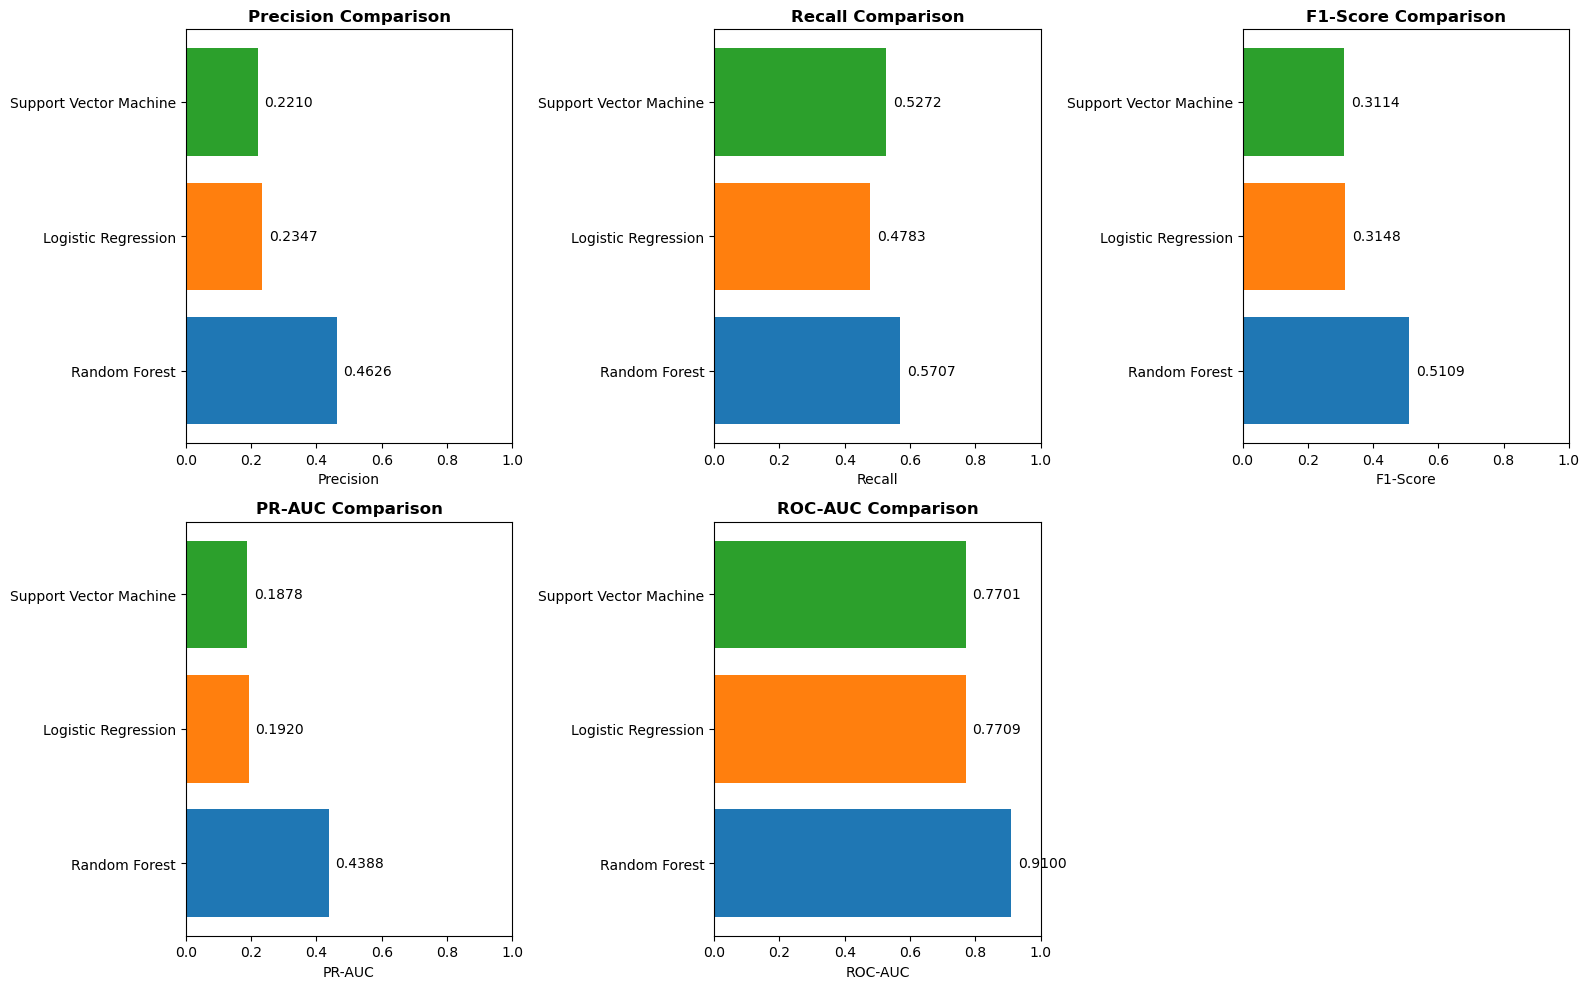

In [57]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics = ['Precision', 'Recall', 'F1-Score', 'PR-AUC', 'ROC-AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    ax.barh(results_comparison['Model'], results_comparison[metric], color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlabel(metric)
    ax.set_xlim(0, 1)
    for i, v in enumerate(results_comparison[metric]):
        ax.text(v + 0.02, i, f'{v:.4f}', va='center')

# Remove extra subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

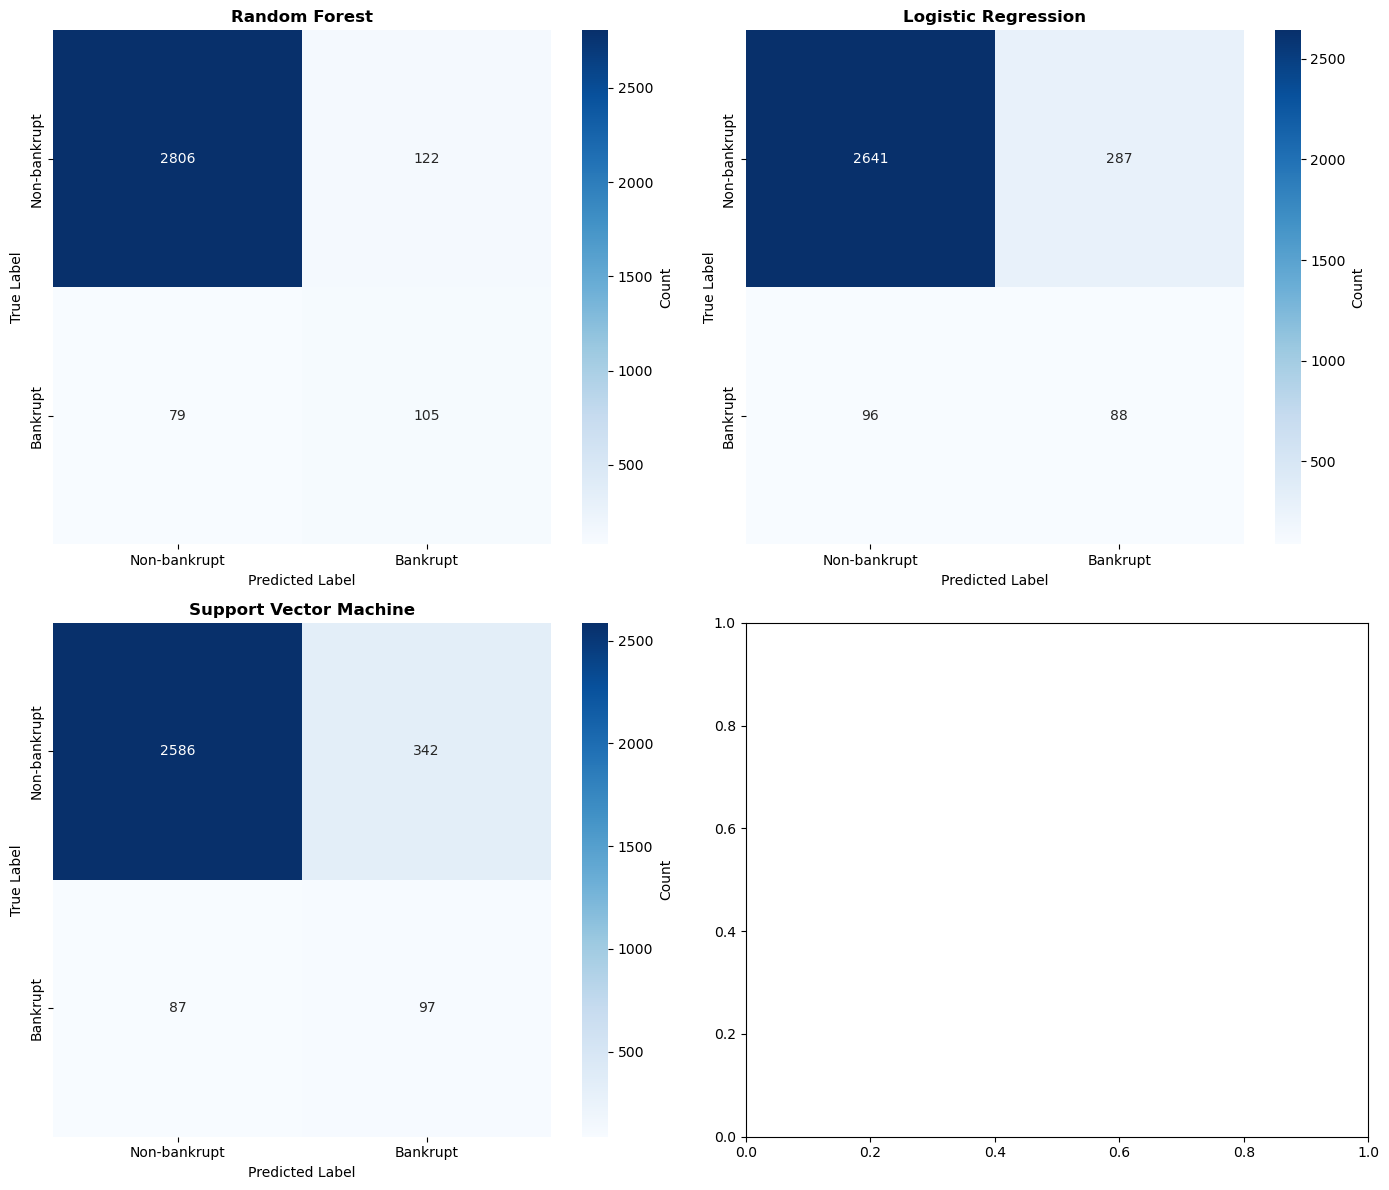

In [59]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

confusion_matrices = [cm_rf, cm_lr, cm_svm]
model_names = ['Random Forest', 'Logistic Regression', 'Support Vector Machine']

for idx, (cm, model_name) in enumerate(zip(confusion_matrices, model_names)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-bankrupt', 'Bankrupt'],
                yticklabels=['Non-bankrupt', 'Bankrupt'],
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

### Best Model

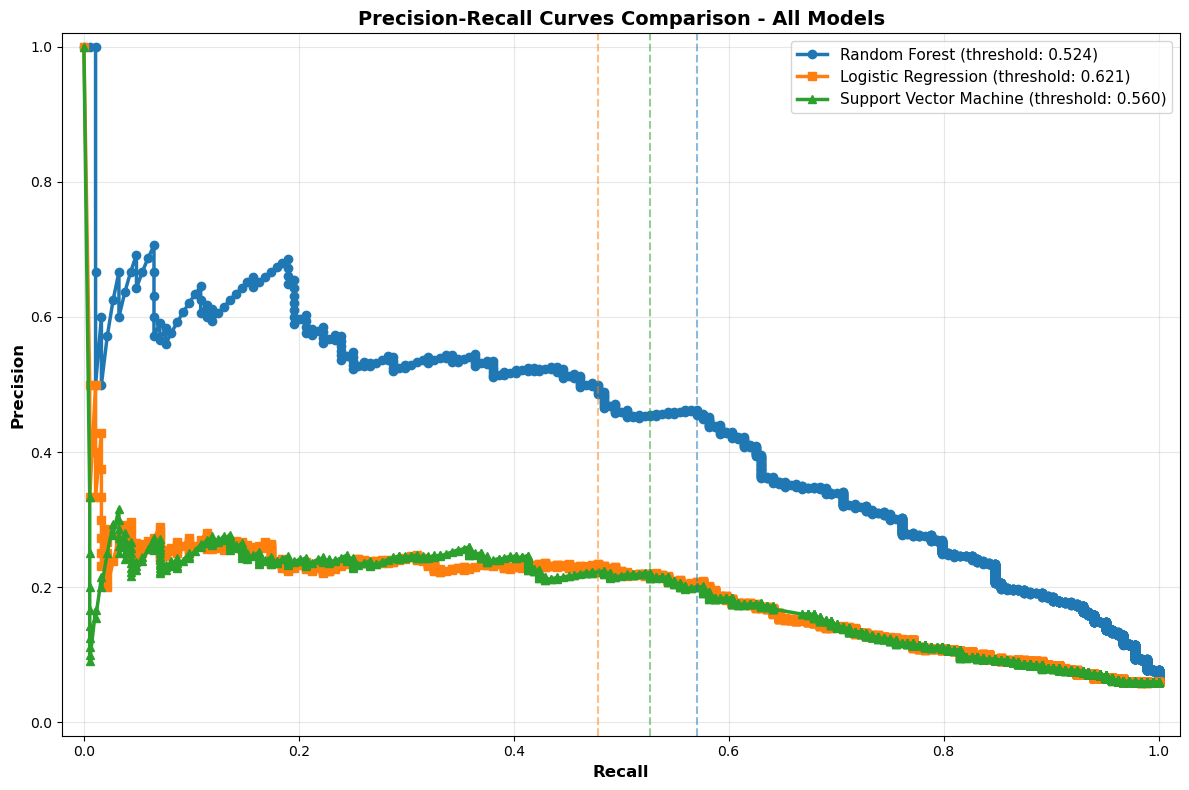

In [60]:
# Plot all PR curves together for comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Plot PR curves for all three models
ax.plot(recall_vals, precision_vals, marker='o', linewidth=2.5, 
        label=f'Random Forest (threshold: {best_threshold:.3f})', color='#1f77b4')
ax.plot(recall_vals_lr, precision_vals_lr, marker='s', linewidth=2.5, 
        label=f'Logistic Regression (threshold: {best_threshold_lr:.3f})', color='#ff7f0e')
ax.plot(recall_vals_svm, precision_vals_svm, marker='^', linewidth=2.5, 
        label=f'Support Vector Machine (threshold: {best_threshold_svm:.3f})', color='#2ca02c')

# Mark optimal thresholds with vertical lines
ax.axvline(recall_vals[best_threshold_idx], color='#1f77b4', linestyle='--', alpha=0.5, linewidth=1.5)
ax.axvline(recall_vals_lr[best_threshold_idx_lr], color='#ff7f0e', linestyle='--', alpha=0.5, linewidth=1.5)
ax.axvline(recall_vals_svm[best_threshold_idx_svm], color='#2ca02c', linestyle='--', alpha=0.5, linewidth=1.5)

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves Comparison - All Models', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)

plt.tight_layout()
plt.show()

In [51]:
# Best model recommendation
best_model_idx = results_comparison['F1-Score'].idxmax()
best_model_name = results_comparison.loc[best_model_idx, 'Model']
best_f1 = results_comparison.loc[best_model_idx, 'F1-Score']

print(f"\n{'=' * 60}")
print(f"BEST MODEL: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")
print(f"{'=' * 60}")


BEST MODEL: Random Forest
F1-Score: 0.5109
